In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from cycler import cycler

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [8]:
sns.set()
plt.style.use("fivethirtyeight")
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [11]:
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c',
          '#aec7e8', '#69B0AC']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

## Team

Read NBA cluster data

In [12]:
df = pd.read_csv('nba_cleaned.csv')
df.shape

(2576, 108)

t-sne

In [14]:
nba_clustering_models = load_pickle('nba_clustering_models')
cluster_dict = nba_clustering_models['cluster_dict']

In [15]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [16]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [17]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [18]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

In [36]:
labels = df['player_cluster'].values
X = df[weights].copy()
X_transformed = X.copy()
queues = ['pre_pca_pipe', 'pca', 'pre_cluster_scaler']
for step in queues:
    X_transformed = nba_clustering_models[step].transform(X_transformed)
tsne = TSNE(perplexity=25, random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

key functions

In [37]:
cluster_dict_detail = {
    1: '(Iso+PnR)', 
    4: '(PnR)',                    
    3: '(Post Up+Roll)', 
    6: '(Roll+Cut)',
    2: '(Roll+Spot Up)',
    7: '(Off Screen)', 
    5: '(Hand Off)', 
    0: '(Spot Up+Transition)'
}

In [38]:
def display_team_distribution(team, season=2022, 
                              df=df, cluster_dict=cluster_dict_detail):
    print(f'{season}-{str(season+1)[2:]} {team}')
    output = df[(df['team'] == team) & (df['season'] == season)].copy()
    cols = ['player', 'mp', 
            'usg_pct', 'ts_pct', 'obpm', 'dbpm', 'bpm',
            'player_cluster', 'player_cluster_discription']
    output['player_cluster_discription'] = output['player_cluster'].map(cluster_dict)
    return output[cols].sort_values('mp', ascending=False).reset_index().drop('index', axis=1)

In [39]:
def player_lookup(player, season=2021, df=df, if_ppp_n_rank=False):
    pdf = df[(df['Player'] == player) & (df['Season'] == season)]
    for idx in pdf.index:
        print(player, pdf.loc[idx]['Team'])
        print('-')
        for col in df.columns:
            if 'Poss%' in col and 'Miscellaneous' not in col:
                print(col, f'{pdf.loc[idx][col]:.2%}')
                if if_ppp_n_rank:
                    ppp_col = col.replace('Poss%', 'PPP')
                    print(ppp_col, f'{pdf.loc[idx][ppp_col]:.3f}')
                    rank_col = col.replace('Poss%', 'Rank')
                    print(rank_col, f'{pdf.loc[idx][rank_col]}')
                print('-')

In [40]:
def plot_players(lookup_idx, labels=labels, X_tsne=X_tsne, 
                 df=df, cluster_dict=cluster_dict):
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_index = [j for j in range(len(labels)) if labels[j] == i]
        plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                    label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
    plt.legend()
    plt.title('TSNE Visualization (Spectral Clustering based on 8 PCA features)')
    for idx in lookup_idx:
        player_coord = X_tsne[idx]
        plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
        plt.annotate(f"{df.loc[idx]['Player']}", 
                     player_coord, alpha=0.6)

## San Antoino Spurs (#1)

In [41]:
display_team_distribution('San Antonio Spurs')

2022-23 San Antonio Spurs


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0          Keldon Johnson  2063     27.9   0.551   0.7  -2.5 -1.8   
1               Tre Jones  1984     19.3   0.534  -0.2  -0.8 -1.0   
2          Malaki Branham  1550     19.1   0.524  -3.0  -2.1 -5.2   
3           Jeremy Sochan  1458     19.8   0.509  -2.8  -1.2 -4.0   
4        Keita Bates-Diop  1452     16.7   0.609   0.3  -0.9 -0.6   
5            Zach Collins  1441     21.2   0.599  -0.5   0.3 -0.2   
6          Doug McDermott  1314     19.2   0.590  -0.7  -2.5 -3.2   
7            Jakob Poeltl  1199     18.6   0.625   0.5   0.4  0.9   
8           Devin Vassell  1178     24.4   0.550   1.3  -0.9  0.4   
9         Josh Richardson   997     20.5   0.556  -0.1  -1.0 -1.1   
10         Romeo Langford   844     15.4   0.524  -2.6  -1.5 -4.2   
11           Blake Wesley   669     18.5   0.393  -7.9  -1.8 -9.6   
12        Devonte' Graham   527     20.2   0.559   1.0  -1.4 -0.4   
13         Charles Bassey   508     15.6   0.658  -0.7   1.3  0.6   
14            Isaiah Roby   474     17.8   0.497  -4.0  -0.6 -4.6   
15        Stanley Johnson   469     15.2   0.625  -0.8  -0.2 -1.0   
16  Sandro Mamukelashvili   443     20.1   0.545   0.3  -2.1 -1.8   
17        Dominick Barlow   408     11.3   0.567  -3.7  -0.8 -4.6   
18           Gorgui Dieng   358     17.9   0.493  -4.0   0.1 -3.9   
19      Julian Champagnie   313     19.3   0.609  -0.3  -2.7 -3.0   

    player_cluster player_cluster_discription  
0                0       (Spot Up+Transition)  
1                4                      (PnR)  
2                4                      (PnR)  
3                4                      (PnR)  
4                0       (Spot Up+Transition)  
5                3             (Post Up+Roll)  
6                5                 (Hand Off)  
7                3             (Post Up+Roll)  
8                4                      (PnR)  
9                4                      (PnR)  
10               0       (Spot Up+Transition)  
11               4                      (PnR)  
12               4                      (PnR)  
13               6                 (Roll+Cut)  
14               0       (Spot Up+Transition)  
15               0       (Spot Up+Transition)  
16               0       (Spot Up+Transition)  
17               6                 (Roll+Cut)  
18               2             (Roll+Spot Up)  
19               0       (Spot Up+Transition)

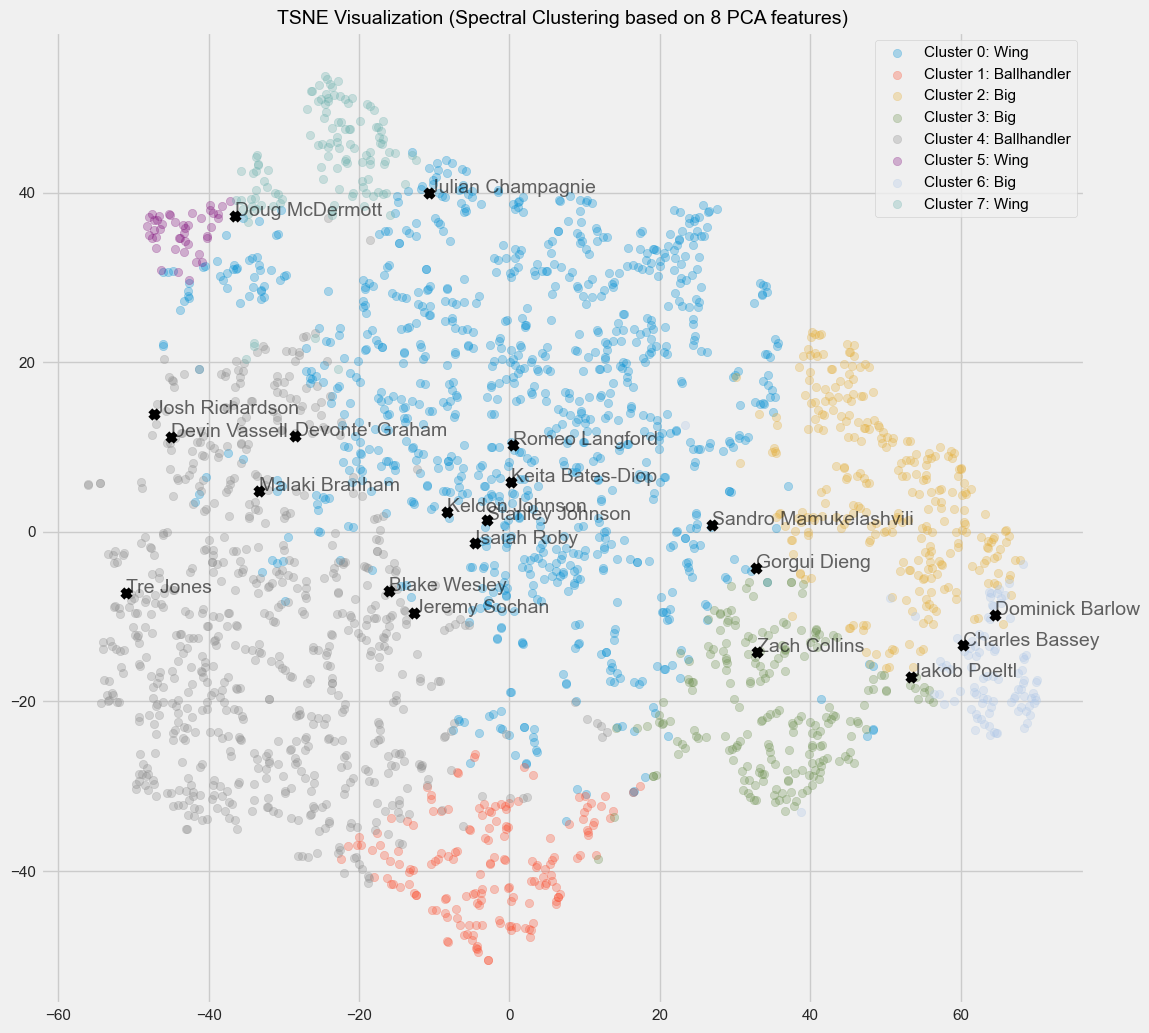

In [42]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'San Antonio Spurs') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Charlotte Hornets (#2)

In [43]:
display_team_distribution('Charlotte Hornets')

2022-23 Charlotte Hornets


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  player_cluster  \
0    P.J. Washington  2380     20.6   0.542  -1.0  -0.3 -1.3               0   
1       Terry Rozier  2221     26.9   0.517   0.6  -1.1 -0.6               4   
2      Mason Plumlee  1597     15.7   0.673   1.5   0.9  2.4               2   
3     Gordon Hayward  1577     20.0   0.563  -1.1  -0.3 -1.4               4   
4    Kelly Oubre Jr.  1548     26.5   0.534  -0.4  -0.7 -1.1               0   
5    Jalen McDaniels  1494     17.5   0.551  -2.7   0.7 -2.0               0   
6   Dennis Smith Jr.  1390     17.6   0.475  -3.5   1.2 -2.2               4   
7        LaMelo Ball  1268     30.0   0.541   3.2  -0.8  2.4               4   
8      Nick Richards  1217     15.6   0.676  -1.0  -0.2 -1.3               6   
9            JT Thor   969     13.1   0.506  -4.3  -0.4 -4.7               0   
10      Théo Maledon   854     17.0   0.515  -3.0   0.5 -2.5               4   
11     Mark Williams   828     17.0   0.659  -0.5   0.6  0.1               6   
12    Bryce McGowens   787     15.0   0.519  -4.6  -1.4 -6.0               0   
13         Kai Jones   550     12.4   0.597  -4.8   0.8 -4.0               0   
14   James Bouknight   515     19.5   0.463  -5.4  -1.1 -6.5               4   
15    Svi Mykhailiuk   428     19.5   0.571   0.3  -0.8 -0.5               0   

   player_cluster_discription  
0        (Spot Up+Transition)  
1                       (PnR)  
2              (Roll+Spot Up)  
3                       (PnR)  
4        (Spot Up+Transition)  
5        (Spot Up+Transition)  
6                       (PnR)  
7                       (PnR)  
8                  (Roll+Cut)  
9        (Spot Up+Transition)  
10                      (PnR)  
11                 (Roll+Cut)  
12       (Spot Up+Transition)  
13       (Spot Up+Transition)  
14                      (PnR)  
15       (Spot Up+Transition)

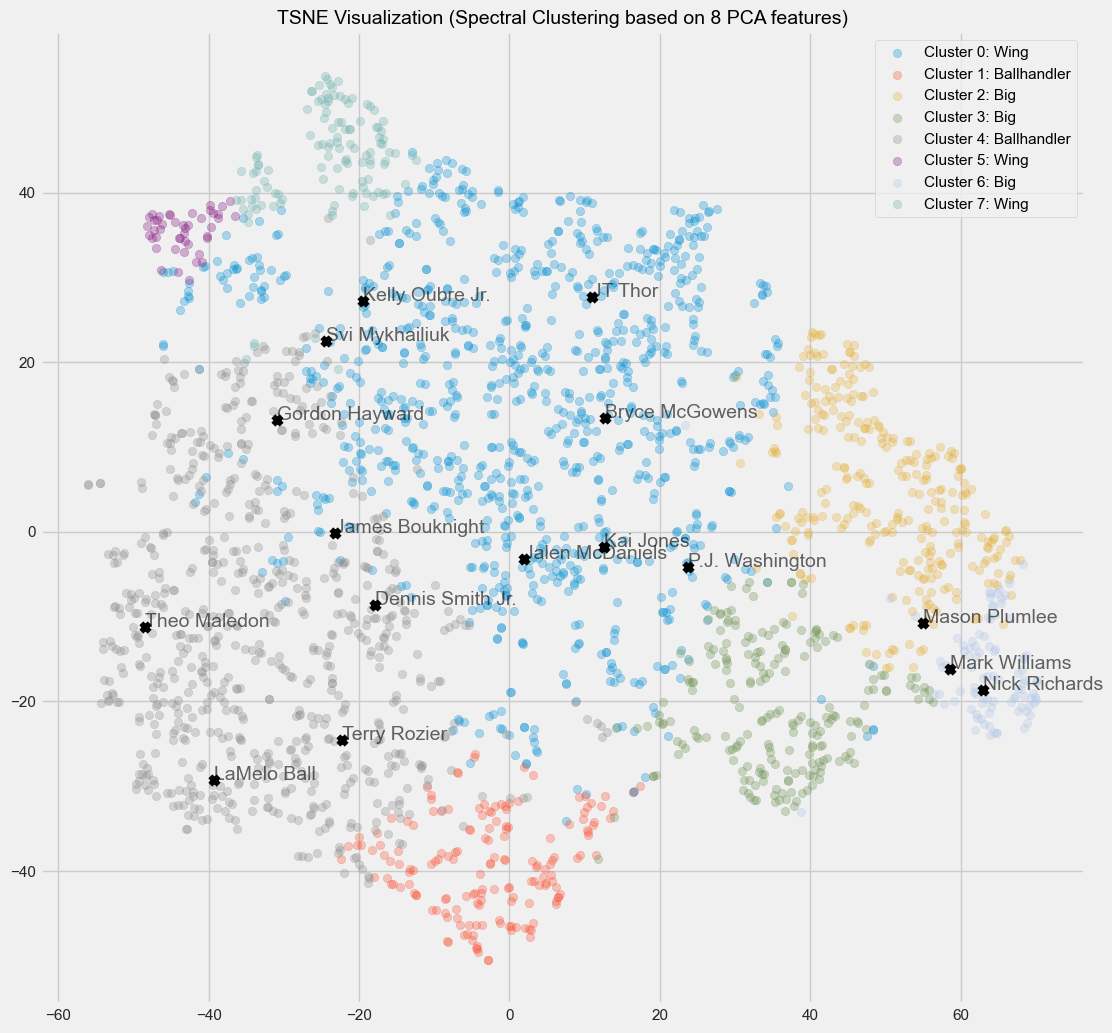

In [44]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Charlotte Hornets') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Portland Trail Blazers (#3)

In [45]:
display_team_distribution('Portland Trail Blazers')

2022-23 Portland Trail Blazers


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  player_cluster  \
0       Jerami Grant  2246     22.8   0.606   1.2  -1.4 -0.2               0   
1    Anfernee Simons  2171     25.1   0.581   1.3  -2.5 -1.1               1   
2     Damian Lillard  2107     33.8   0.645   8.3  -1.2  7.1               1   
3     Shaedon Sharpe  1779     19.0   0.568  -1.3  -2.0 -3.3               0   
4          Josh Hart  1704     12.6   0.586  -0.9   0.7 -0.2               0   
5       Drew Eubanks  1584     12.5   0.666  -0.9   0.9  0.1               2   
6       Jusuf Nurkić  1391     22.1   0.589  -0.6   0.7  0.1               3   
7    Trendon Watford  1182     16.1   0.625  -1.4  -0.4 -1.8               0   
8      Nassir Little   976     16.0   0.555  -1.6  -1.4 -3.0               0   
9    Justise Winslow   776     14.2   0.466  -3.4   0.6 -2.8               0   
10     Jabari Walker   619     17.3   0.496  -3.9  -2.1 -6.1               0   
11  Matisse Thybulle   609     11.4   0.566  -2.2   1.1 -1.2               0   
12       Cam Reddish   552     17.8   0.563  -3.0  -1.4 -4.3               0   
13      Keon Johnson   416     25.0   0.482  -3.8  -1.6 -5.4               1   
14        Kevin Knox   359     22.1   0.540  -2.0  -2.7 -4.6               0   

   player_cluster_discription  
0        (Spot Up+Transition)  
1                   (Iso+PnR)  
2                   (Iso+PnR)  
3        (Spot Up+Transition)  
4        (Spot Up+Transition)  
5              (Roll+Spot Up)  
6              (Post Up+Roll)  
7        (Spot Up+Transition)  
8        (Spot Up+Transition)  
9        (Spot Up+Transition)  
10       (Spot Up+Transition)  
11       (Spot Up+Transition)  
12       (Spot Up+Transition)  
13                  (Iso+PnR)  
14       (Spot Up+Transition)

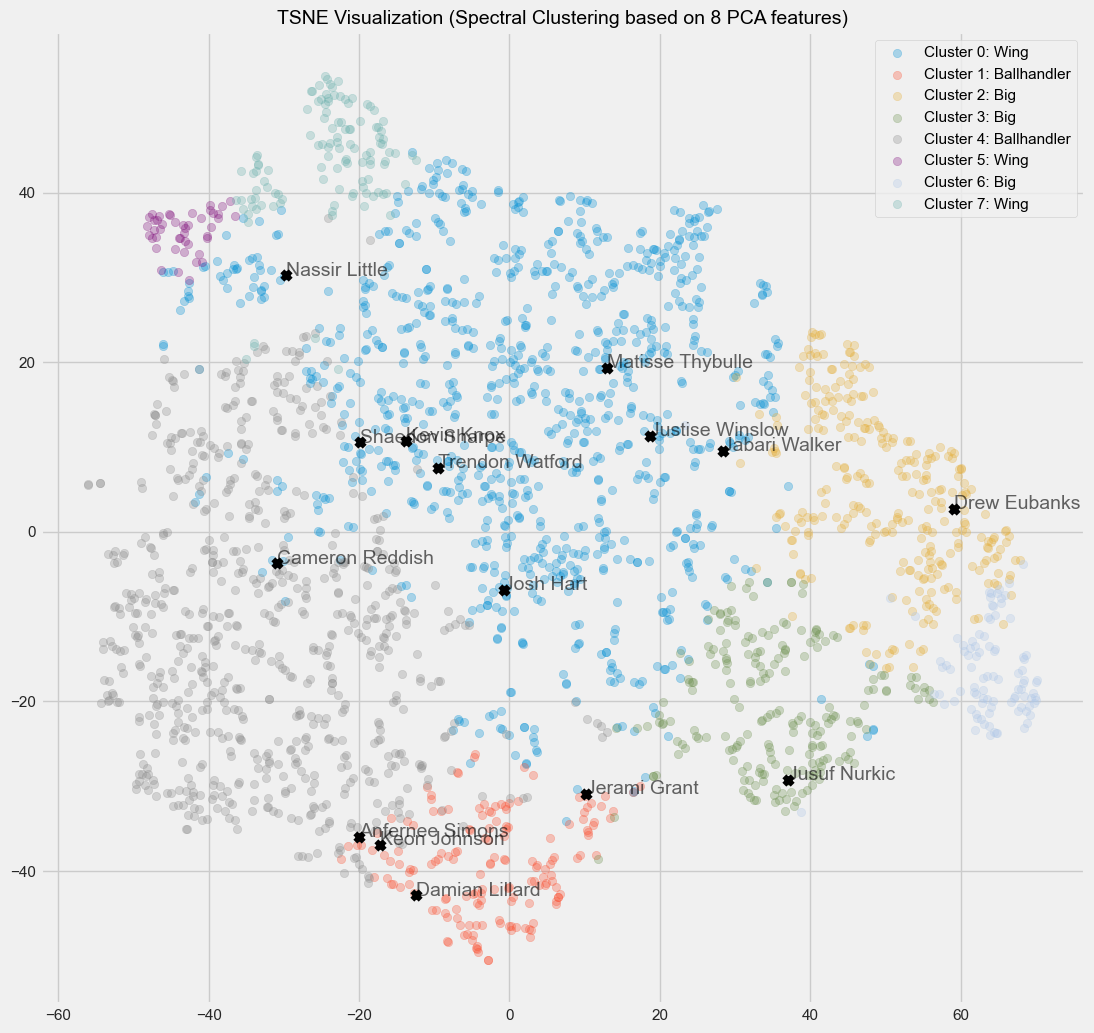

In [46]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Portland Trail Blazers') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Houston Rockets (#4)

In [47]:
display_team_distribution('Houston Rockets')

2022-23 Houston Rockets


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0           Jalen Green  2602     28.1   0.538   0.5  -2.6 -2.1   
1      Jabari Smith Jr.  2451     18.4   0.514  -2.3  -1.3 -3.7   
2     Kenyon Martin Jr.  2292     16.4   0.635   0.6  -1.3 -0.7   
3        Alperen Şengün  2171     21.4   0.599   1.1   0.4  1.4   
4      Kevin Porter Jr.  2024     24.3   0.565   1.4  -0.8  0.6   
5            Tari Eason  1767     19.3   0.525  -1.3  -0.4 -1.7   
6           Eric Gordon  1418     18.1   0.572  -0.9  -1.7 -2.6   
7          Usman Garuba   970     10.5   0.569  -2.0   0.6 -1.4   
8           Daishen Nix   914     15.4   0.447  -5.0  -1.5 -6.5   
9      Josh Christopher   786     21.9   0.523  -3.0  -1.4 -4.3   
10        Jae'Sean Tate   677     18.8   0.546  -2.8  -0.7 -3.5   
11     Garrison Mathews   602     14.3   0.564  -2.3  -0.2 -2.5   
12  TyTy Washington Jr.   433     17.4   0.432  -5.0  -1.3 -6.3   
13       Bruno Fernando   364     15.1   0.561  -2.8   1.1 -1.7   

    player_cluster player_cluster_discription  
0                4                      (PnR)  
1                0       (Spot Up+Transition)  
2                0       (Spot Up+Transition)  
3                3             (Post Up+Roll)  
4                4                      (PnR)  
5                0       (Spot Up+Transition)  
6                4                      (PnR)  
7                2             (Roll+Spot Up)  
8                4                      (PnR)  
9                0       (Spot Up+Transition)  
10               0       (Spot Up+Transition)  
11               5                 (Hand Off)  
12               4                      (PnR)  
13               2             (Roll+Spot Up)

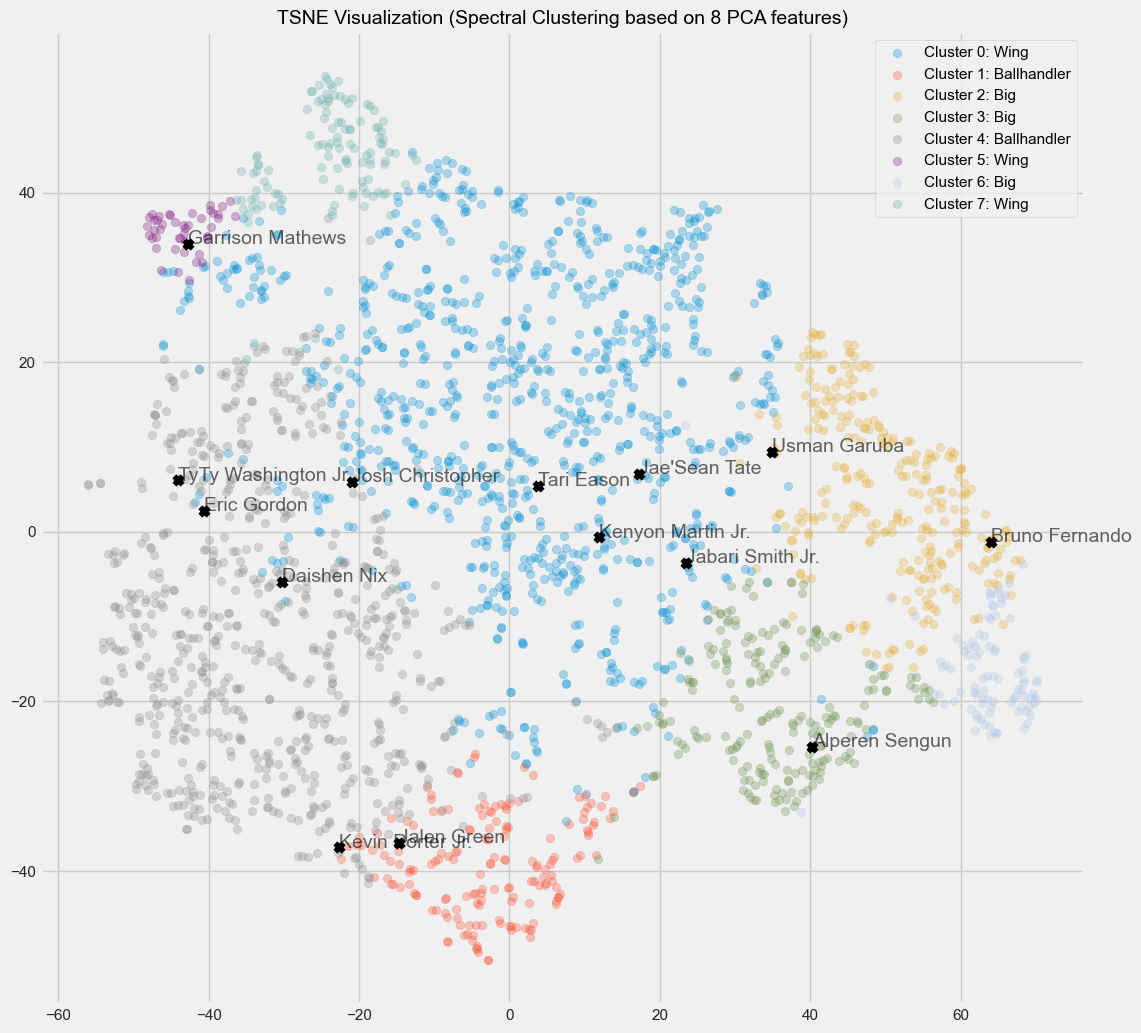

In [48]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Houston Rockets') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Detroit Pistons (#5)

In [49]:
display_team_distribution('Detroit Pistons')

2022-23 Detroit Pistons


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  player_cluster  \
0          Jaden Ivey  2304     25.4   0.528  -1.4  -1.9 -3.3               4   
1       Killian Hayes  2154     20.5   0.455  -3.3  -0.5 -3.8               4   
2    Bojan Bogdanović  1893     25.9   0.627   2.6  -1.8  0.8               7   
3         Jalen Duren  1670     14.3   0.655  -0.4  -0.4 -0.8               6   
4          Saddiq Bey  1500     21.3   0.552   0.5  -1.1 -0.7               0   
5      Isaiah Stewart  1414     17.3   0.560  -1.0  -1.1 -2.1               0   
6         Cory Joseph  1227     15.2   0.558  -0.7  -0.8 -1.5               4   
7       Isaiah Livers  1199     11.9   0.567  -2.1  -0.3 -2.4               0   
8          Alec Burks  1122     22.8   0.602   1.8  -0.5  1.2               4   
9      Hamidou Diallo   996     21.8   0.593  -1.8   0.4 -1.4               0   
10  Marvin Bagley III   990     20.4   0.587   0.3  -1.2 -0.9               3   
11      James Wiseman   605     21.7   0.563  -2.5  -1.8 -4.3               3   
12         Kevin Knox   593     16.2   0.612  -2.1  -0.6 -2.8               0   
13    Rodney McGruder   524     14.0   0.566  -0.8  -0.7 -1.5               0   
14    Cade Cunningham   400     30.0   0.492  -0.1  -0.6 -0.7               4   
15       R.J. Hampton   389     17.6   0.546  -3.0  -1.4 -4.4               0   
16     Eugene Omoruyi   373     19.7   0.533  -2.9  -1.2 -4.1               0   

   player_cluster_discription  
0                       (PnR)  
1                       (PnR)  
2                (Off Screen)  
3                  (Roll+Cut)  
4        (Spot Up+Transition)  
5        (Spot Up+Transition)  
6                       (PnR)  
7        (Spot Up+Transition)  
8                       (PnR)  
9        (Spot Up+Transition)  
10             (Post Up+Roll)  
11             (Post Up+Roll)  
12       (Spot Up+Transition)  
13       (Spot Up+Transition)  
14                      (PnR)  
15       (Spot Up+Transition)  
16       (Spot Up+Transition)

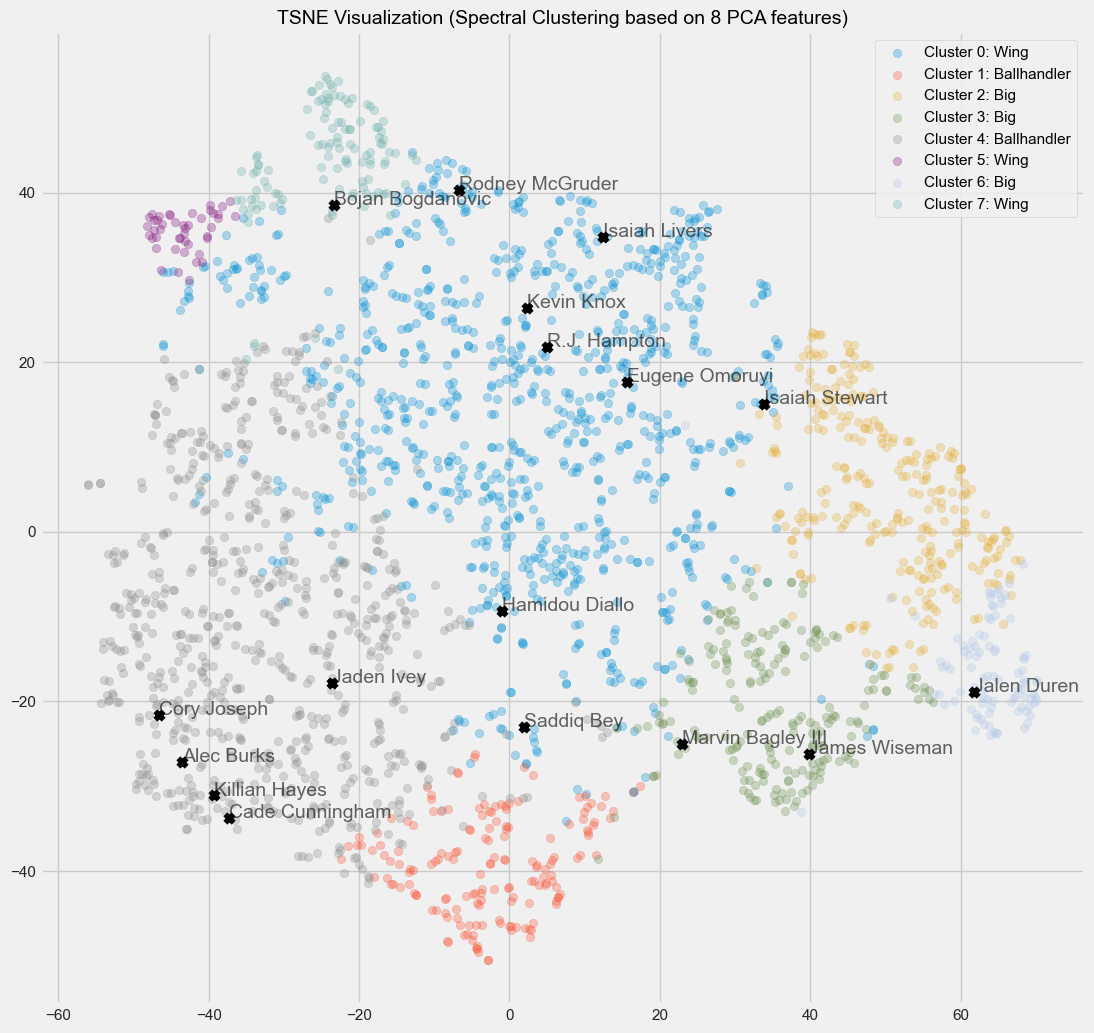

In [50]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Detroit Pistons') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Orlando Magic (#6, 11)

In [51]:
display_team_distribution('Orlando Magic')

2022-23 Orlando Magic


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0         Franz Wagner  2609     23.5   0.589   0.4  -0.5 -0.1   
1       Paolo Banchero  2430     27.5   0.529  -0.7  -0.7 -1.5   
2       Markelle Fultz  1778     21.3   0.564  -0.1   0.7  0.5   
3   Wendell Carter Jr.  1690     20.5   0.621   0.9   0.1  1.0   
4         Cole Anthony  1552     21.5   0.570   0.7   0.5  1.3   
5              Bol Bol  1505     18.2   0.603  -1.8   0.9 -0.9   
6          Jalen Suggs  1246     20.3   0.528  -1.8   0.8 -1.0   
7          Gary Harris  1184     12.6   0.620  -1.4   0.7 -0.7   
8        Moritz Wagner  1109     21.1   0.630   0.4   0.2  0.6   
9        Terrence Ross   944     15.7   0.543  -2.7  -0.4 -3.1   
10       Caleb Houstan   812     11.0   0.508  -3.1  -0.9 -4.0   
11            Mo Bamba   681     16.3   0.613   0.4   0.9  1.3   
12         Chuma Okeke   518     12.3   0.488  -2.4   0.8 -1.6   
13        Kevon Harris   457     13.7   0.564  -3.5  -0.1 -3.6   
14   Admiral Schofield   451     14.1   0.587  -2.2  -0.7 -2.9   
15        R.J. Hampton   361     18.0   0.572  -1.5   0.3 -1.2   

    player_cluster player_cluster_discription  
0                4                      (PnR)  
1                1                  (Iso+PnR)  
2                4                      (PnR)  
3                2             (Roll+Spot Up)  
4                4                      (PnR)  
5                0       (Spot Up+Transition)  
6                4                      (PnR)  
7                0       (Spot Up+Transition)  
8                2             (Roll+Spot Up)  
9                5                 (Hand Off)  
10               0       (Spot Up+Transition)  
11               2             (Roll+Spot Up)  
12               0       (Spot Up+Transition)  
13               0       (Spot Up+Transition)  
14               0       (Spot Up+Transition)  
15               4                      (PnR)

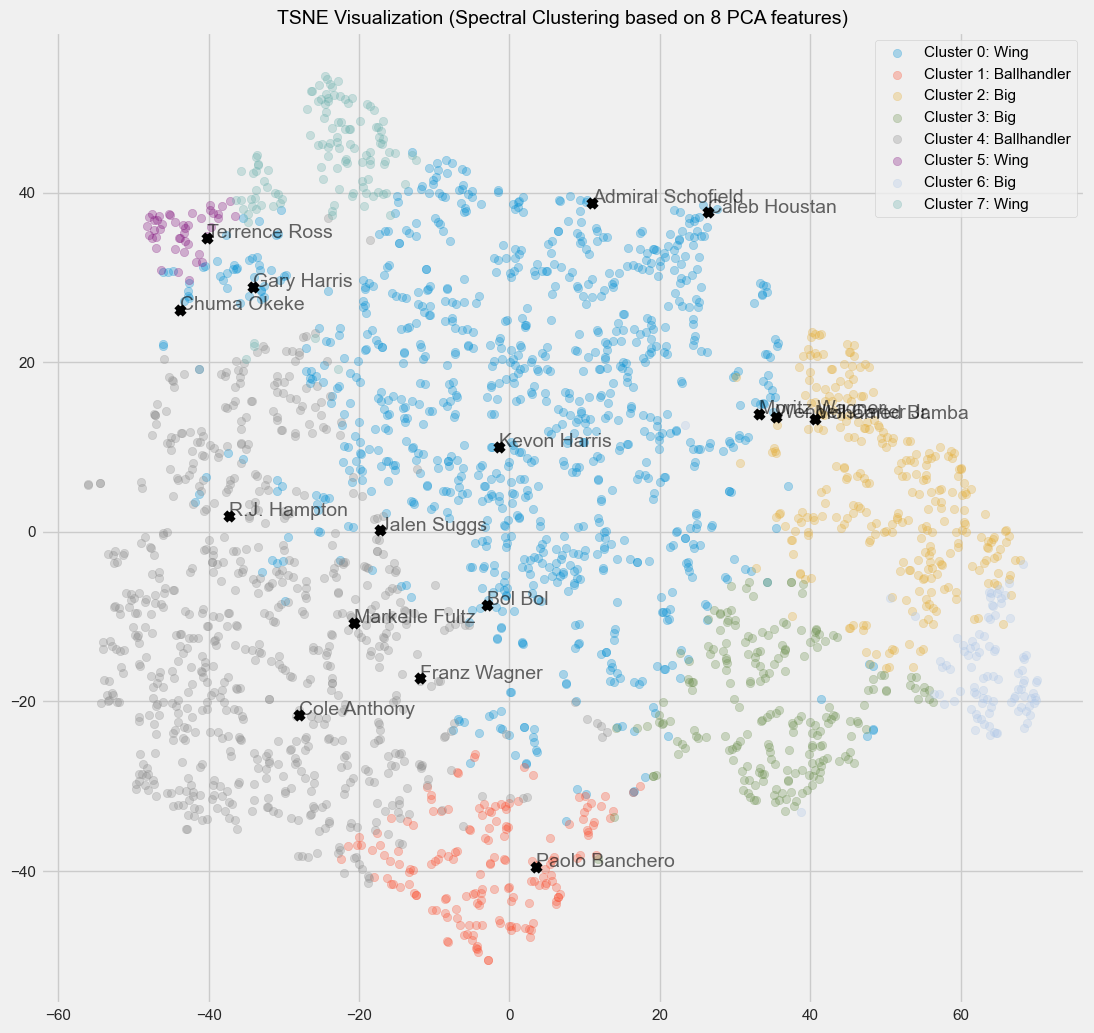

In [52]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Orlando Magic') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Indiana Pacers (#7)

In [53]:
display_team_distribution('Indiana Pacers')

2022-23 Indiana Pacers


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0          Buddy Hield  2482     20.8   0.614   2.5  -0.6  1.9   
1   Bennedict Mathurin  2222     24.6   0.566  -1.2  -2.5 -3.7   
2      Andrew Nembhard  2073     16.1   0.528  -2.4  -0.8 -3.2   
3    Tyrese Haliburton  1883     23.8   0.624   7.0   0.2  7.2   
4         Myles Turner  1825     22.0   0.651   1.4   0.7  2.1   
5        Aaron Nesmith  1816     16.8   0.566  -2.3  -0.7 -3.0   
6       T.J. McConnell  1526     19.1   0.590   0.4   0.1  0.5   
7          Jalen Smith  1279     21.0   0.565  -0.9  -1.1 -2.1   
8       Oshae Brissett  1083     16.1   0.520  -2.0  -1.2 -3.2   
9       Isaiah Jackson  1042     17.4   0.595  -1.7   0.9 -0.8   
10        Chris Duarte   897     19.0   0.496  -2.9  -1.6 -4.5   
11        Jordan Nwora   591     21.2   0.586   0.4  -2.2 -1.8   

    player_cluster player_cluster_discription  
0                0       (Spot Up+Transition)  
1                0       (Spot Up+Transition)  
2                4                      (PnR)  
3                4                      (PnR)  
4                2             (Roll+Spot Up)  
5                0       (Spot Up+Transition)  
6                4                      (PnR)  
7                2             (Roll+Spot Up)  
8                0       (Spot Up+Transition)  
9                2             (Roll+Spot Up)  
10               4                      (PnR)  
11               0       (Spot Up+Transition)

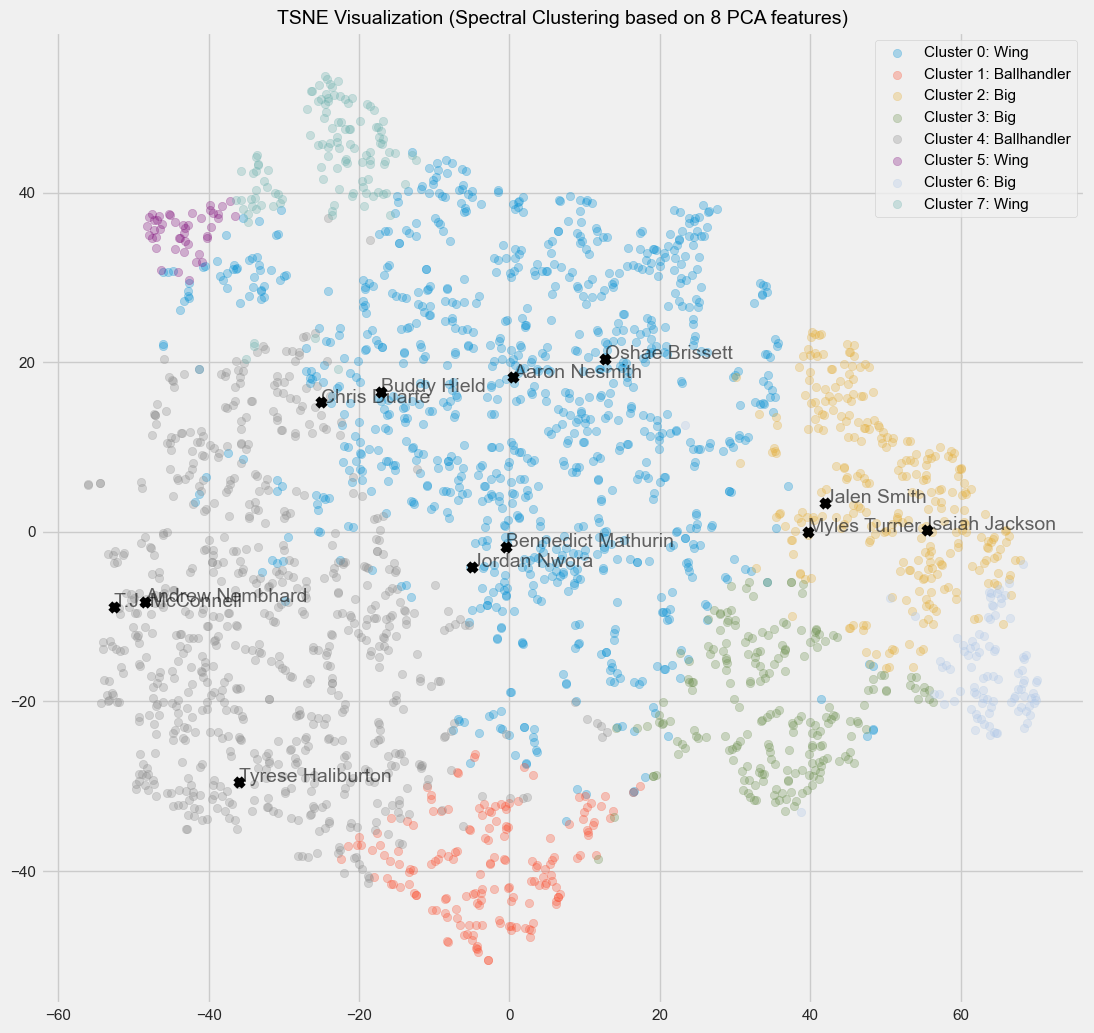

In [54]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Indiana Pacers') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Washington Wizards (#8)

In [55]:
display_team_distribution('Washington Wizards')

2022-23 Washington Wizards


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0           Kyle Kuzma  2239     27.9   0.544  -0.2  -1.5 -1.7   
1   Kristaps Porziņģis  2120     27.4   0.627   3.8   0.5  4.3   
2        Corey Kispert  2093     14.1   0.657  -0.1  -1.4 -1.5   
3          Deni Avdija  2020     16.7   0.535  -2.8   0.5 -2.3   
4         Monte Morris  1695     15.6   0.579   0.8  -0.4  0.5   
5         Bradley Beal  1673     29.2   0.593   2.9  -1.2  1.8   
6       Daniel Gafford  1604     15.2   0.739   0.4   0.6  1.0   
7         Delon Wright  1221     12.9   0.581   0.4   3.1  3.4   
8       Jordan Goodwin  1106     17.3   0.531  -0.7   1.4  0.7   
9          Will Barton   782     19.4   0.504  -1.7  -0.9 -2.7   
10       Rui Hachimura   728     23.0   0.558  -1.2  -1.4 -2.6   
11        Anthony Gill   624     12.3   0.604  -2.4  -0.9 -3.3   
12          Taj Gibson   480     15.3   0.585  -3.6   0.5 -3.2   
13       Kendrick Nunn   436     24.2   0.563  -0.4  -1.3 -1.6   
14        Johnny Davis   423     20.5   0.446  -5.8  -1.7 -7.4   

    player_cluster player_cluster_discription  
0                0       (Spot Up+Transition)  
1                3             (Post Up+Roll)  
2                0       (Spot Up+Transition)  
3                0       (Spot Up+Transition)  
4                4                      (PnR)  
5                1                  (Iso+PnR)  
6                6                 (Roll+Cut)  
7                4                      (PnR)  
8                4                      (PnR)  
9                4                      (PnR)  
10               0       (Spot Up+Transition)  
11               0       (Spot Up+Transition)  
12               2             (Roll+Spot Up)  
13               4                      (PnR)  
14               0       (Spot Up+Transition)

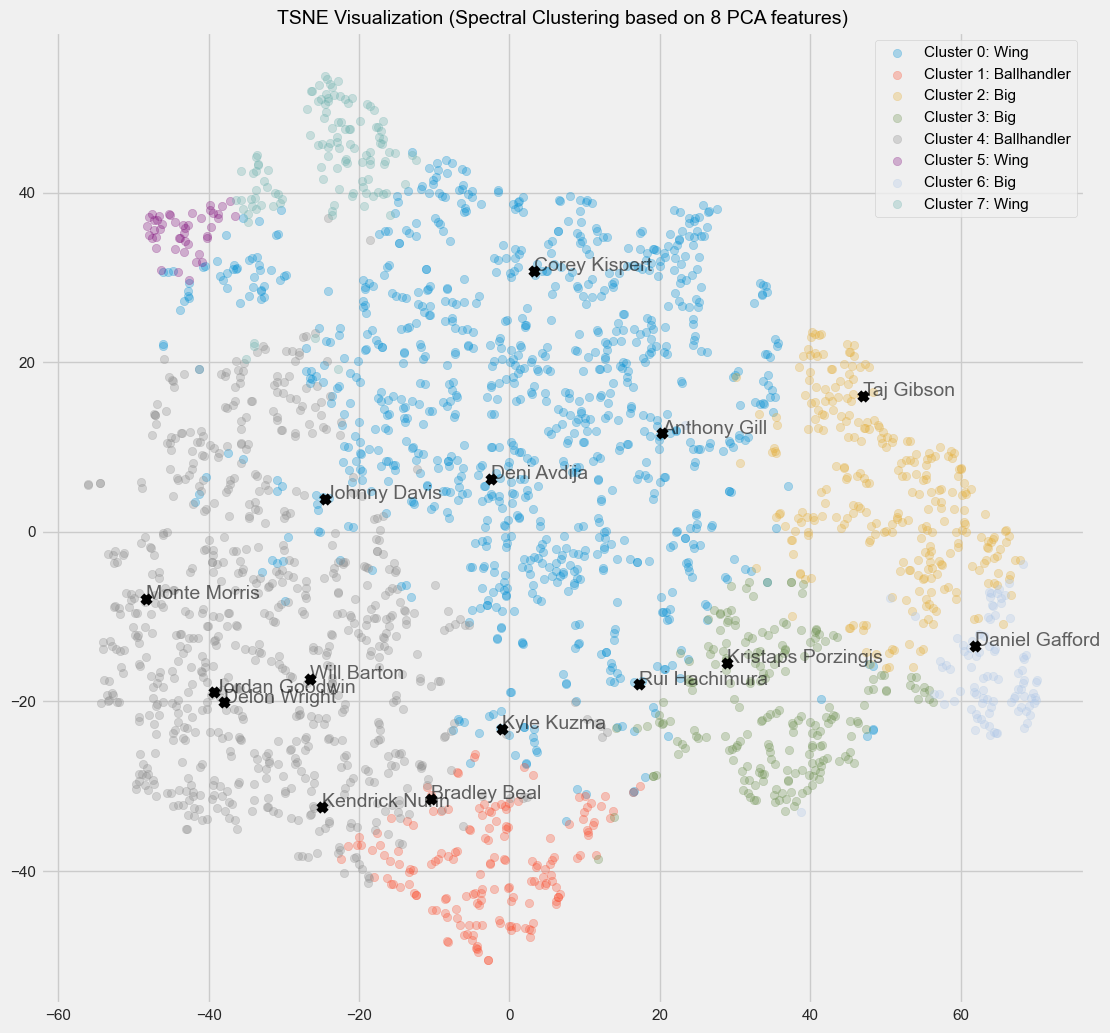

In [56]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Washington Wizards') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Utah Jazz (#9, 16)

In [57]:
display_team_distribution('Utah Jazz')

2022-23 Utah Jazz


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0            Lauri Markkanen  2273     26.6   0.640   4.9  -1.0  3.8   
1            Jordan Clarkson  1988     27.8   0.558   1.0  -2.4 -1.4   
2               Kelly Olynyk  1942     17.8   0.643  -0.4   0.9  0.4   
3             Walker Kessler  1703     13.3   0.702   1.4   1.5  2.9   
4              Malik Beasley  1472     21.2   0.535  -0.4  -1.2 -1.6   
5        Talen Horton-Tucker  1313     25.9   0.508  -1.1  -0.5 -1.6   
6                Mike Conley  1276     16.1   0.552   0.7  -0.5  0.2   
7          Jarred Vanderbilt  1254     14.1   0.607   0.0   1.5  1.5   
8               Ochai Agbaji  1209     15.8   0.561  -1.7  -1.4 -3.0   
9              Collin Sexton  1145     23.4   0.616   0.1  -1.5 -1.3   
10                  Rudy Gay   816     17.7   0.475  -3.6  -0.4 -4.0   
11         Simone Fontecchio   766     20.2   0.495  -3.0  -2.1 -5.2   
12                 Kris Dunn   568     20.2   0.606   0.7   1.7  2.4   
13  Nickeil Alexander-Walker   528     18.4   0.609  -0.6   1.1  0.5   
14            Udoka Azubuike   359     11.5   0.774  -1.2   0.5 -0.6   
15     Juan Toscano-Anderson   335     12.2   0.457  -4.7   0.4 -4.3   
16              Damian Jones   301      9.3   0.821  -1.7   0.2 -1.5   

    player_cluster player_cluster_discription  
0                7               (Off Screen)  
1                4                      (PnR)  
2                0       (Spot Up+Transition)  
3                6                 (Roll+Cut)  
4                7               (Off Screen)  
5                4                      (PnR)  
6                4                      (PnR)  
7                0       (Spot Up+Transition)  
8                7               (Off Screen)  
9                0       (Spot Up+Transition)  
10               0       (Spot Up+Transition)  
11               7               (Off Screen)  
12               0       (Spot Up+Transition)  
13               4                      (PnR)  
14               2             (Roll+Spot Up)  
15               0       (Spot Up+Transition)  
16               0       (Spot Up+Transition)

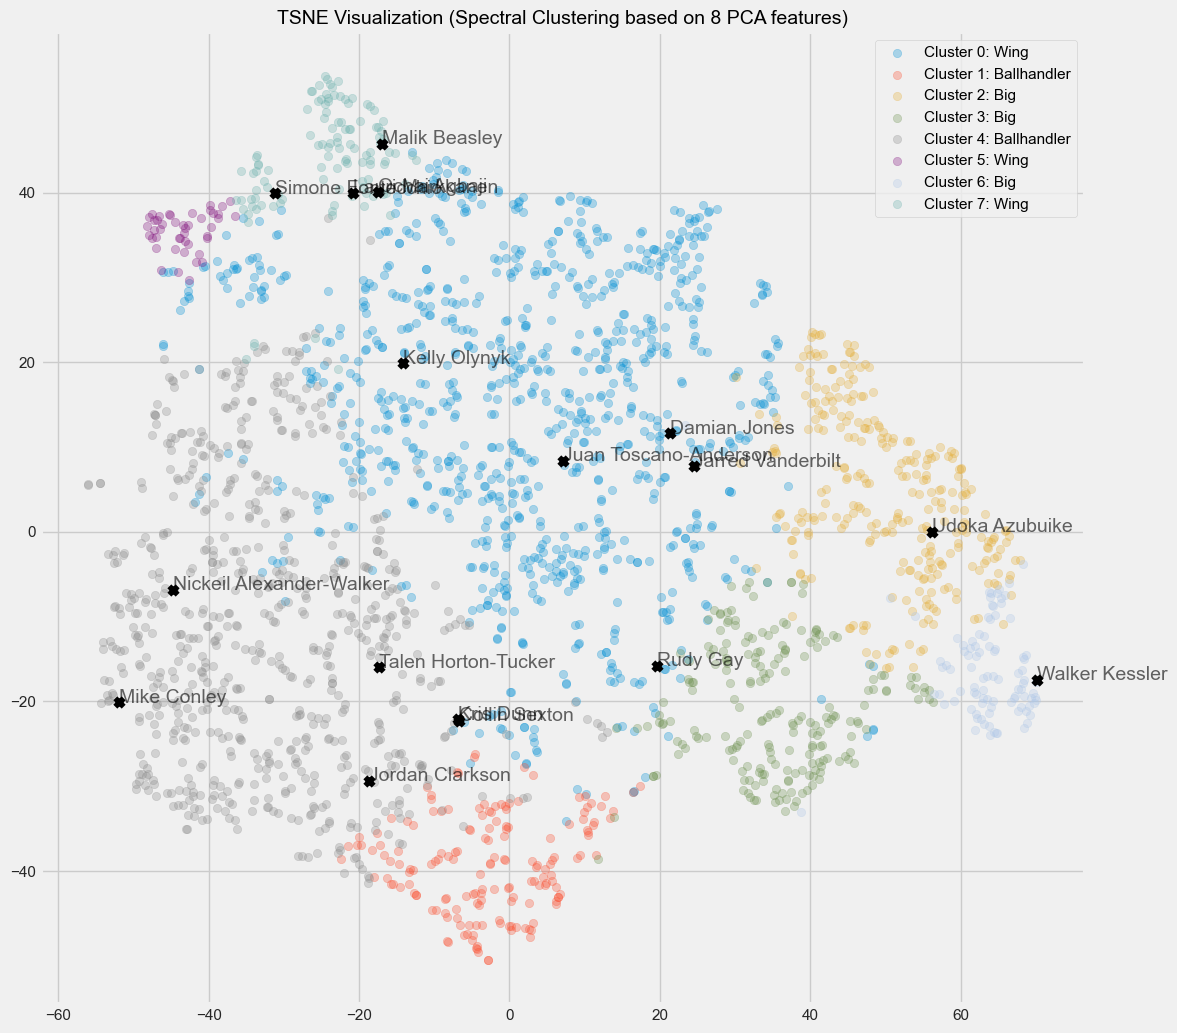

In [58]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Utah Jazz') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Dallas Mavericks (#10)

In [59]:
display_team_distribution('Dallas Mavericks')

2022-23 Dallas Mavericks


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0           Luka Dončić  2391     37.6   0.609   7.6   1.4  8.9   
1        Reggie Bullock  2364     10.0   0.577  -2.3  -0.3 -2.6   
2      Tim Hardaway Jr.  2152     20.6   0.554  -0.3  -1.5 -1.8   
3     Spencer Dinwiddie  1808     21.9   0.599   2.0  -1.2  0.9   
4        Christian Wood  1738     26.4   0.624   1.9  -0.3  1.7   
5            Josh Green  1539     14.6   0.645  -1.9  -0.6 -2.4   
6         Dwight Powell  1458     12.6   0.738  -1.2   0.0 -1.2   
7   Dorian Finney-Smith  1288     12.8   0.557  -0.9  -0.2 -1.1   
8           Maxi Kleber   930     10.3   0.592  -2.2   0.0 -2.2   
9          Kyrie Irving   763     27.4   0.634   5.3  -0.4  4.9   
10          Jaden Hardy   708     26.4   0.571  -0.4  -1.9 -2.3   
11      Frank Ntilikina   607     13.1   0.461  -6.1  -0.7 -6.7   
12        Dāvis Bertāns   492     16.2   0.618   0.0  -1.3 -1.2   
13         JaVale McGee   355     22.8   0.650  -3.6  -0.1 -3.7   
14   McKinley Wright IV   335     16.9   0.536  -1.9  -0.8 -2.7   
15          Theo Pinson   323     14.7   0.512  -2.5  -0.9 -3.4   

    player_cluster player_cluster_discription  
0                1                  (Iso+PnR)  
1                0       (Spot Up+Transition)  
2                0       (Spot Up+Transition)  
3                1                  (Iso+PnR)  
4                0       (Spot Up+Transition)  
5                0       (Spot Up+Transition)  
6                2             (Roll+Spot Up)  
7                0       (Spot Up+Transition)  
8                0       (Spot Up+Transition)  
9                1                  (Iso+PnR)  
10               1                  (Iso+PnR)  
11               0       (Spot Up+Transition)  
12               0       (Spot Up+Transition)  
13               2             (Roll+Spot Up)  
14               4                      (PnR)  
15               0       (Spot Up+Transition)

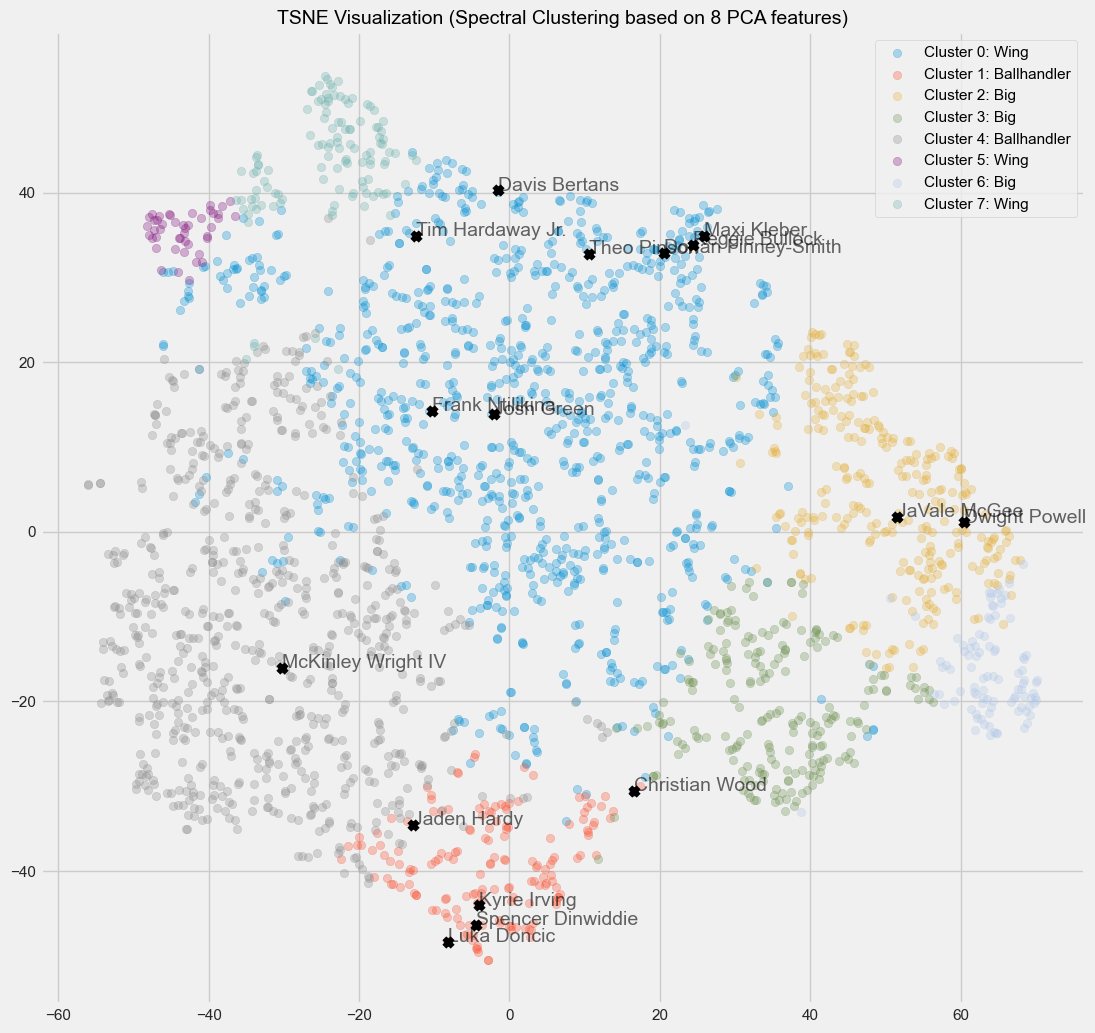

In [60]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Dallas Mavericks') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Oklahoma City Thunder (#12)

In [61]:
display_team_distribution('Oklahoma City Thunder')

2022-23 Oklahoma City Thunder


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0   Shai Gilgeous-Alexander  2416     32.8   0.626   5.7   1.5  7.3   
1               Josh Giddey  2367     24.6   0.533   1.5  -0.3  1.2   
2            Jalen Williams  2276     18.4   0.601  -0.4   0.7  0.3   
3             Luguentz Dort  2272     19.8   0.513  -2.0  -1.0 -3.0   
4                Isaiah Joe  1395     17.7   0.626   1.3  -0.4  0.9   
5             Aaron Wiggins  1297     14.5   0.607  -1.5  -0.5 -2.1   
6          Kenrich Williams  1206     13.7   0.585   0.1   0.4  0.5   
7                  Tre Mann  1183     20.7   0.492  -3.0  -1.0 -3.9   
8           Jaylin Williams   914     13.5   0.559  -2.3   0.6 -1.7   
9    Jeremiah Robinson-Earl   814     14.6   0.548  -0.8  -0.7 -1.5   
10       Aleksej Pokusevski   701     18.3   0.522  -1.0   1.0  0.0   
11             Mike Muscala   622     15.7   0.602   0.3  -0.1  0.1   
12            Ousmane Dieng   569     15.9   0.505  -3.1  -0.5 -3.6   
13            Darius Bazley   555     15.7   0.525  -1.8   0.8 -1.0   
14         Lindy Waters III   531     15.5   0.573   0.5  -0.4  0.1   

    player_cluster player_cluster_discription  
0                1                  (Iso+PnR)  
1                4                      (PnR)  
2                0       (Spot Up+Transition)  
3                0       (Spot Up+Transition)  
4                0       (Spot Up+Transition)  
5                0       (Spot Up+Transition)  
6                0       (Spot Up+Transition)  
7                4                      (PnR)  
8                2             (Roll+Spot Up)  
9                0       (Spot Up+Transition)  
10               2             (Roll+Spot Up)  
11               2             (Roll+Spot Up)  
12               0       (Spot Up+Transition)  
13               0       (Spot Up+Transition)  
14               0       (Spot Up+Transition)

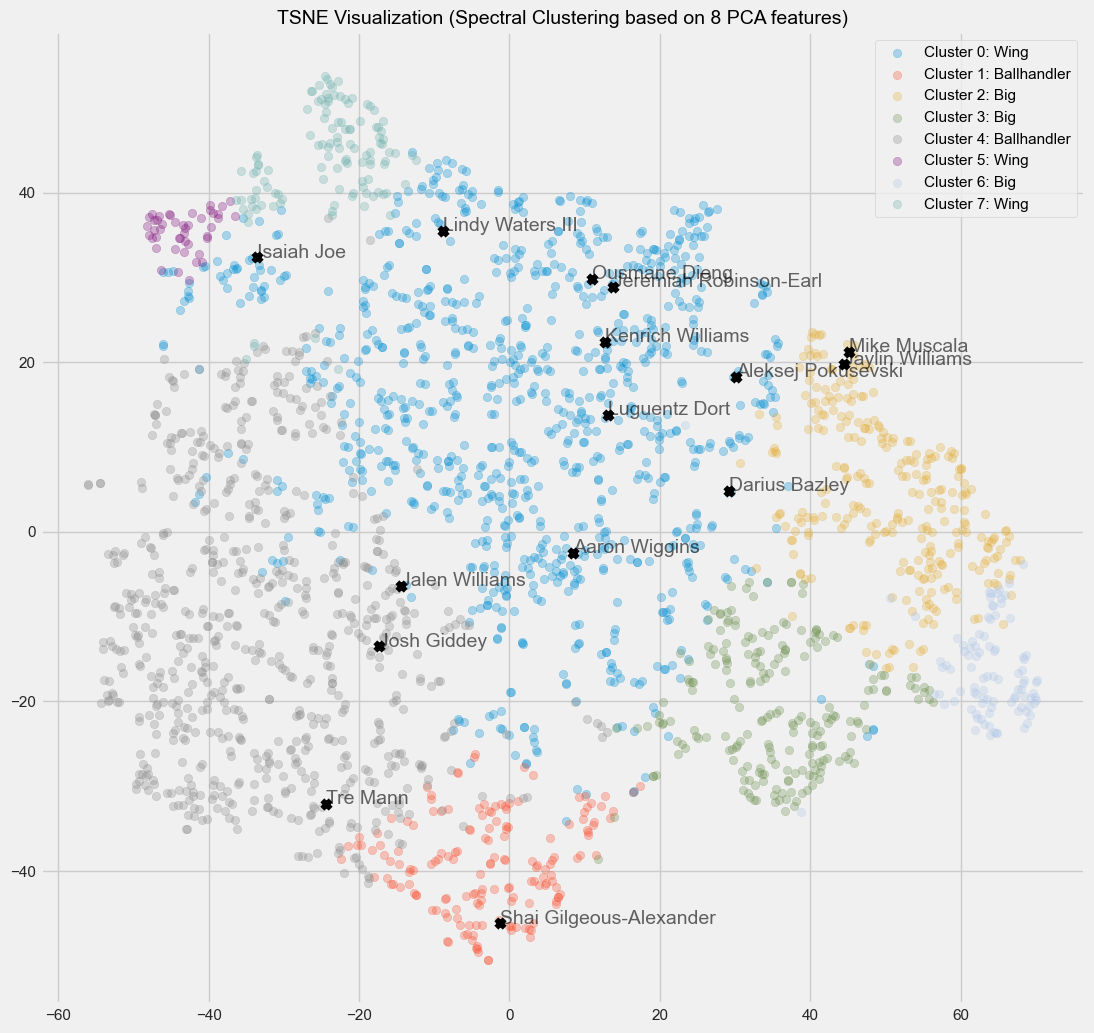

In [62]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Oklahoma City Thunder') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Toronto Raptors (#13)

In [63]:
display_team_distribution('Toronto Raptors')

2022-23 Toronto Raptors


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0        Scottie Barnes  2678     20.3   0.524   0.5  -0.1  0.4   
1         Pascal Siakam  2652     27.2   0.565   3.3  -0.1  3.1   
2         Fred VanVleet  2535     23.2   0.540   2.0   0.5  2.5   
3            OG Anunoby  2386     19.5   0.586  -0.3   0.7  0.4   
4        Gary Trent Jr.  2118     21.7   0.560   0.2   0.0  0.2   
5         Chris Boucher  1523     18.0   0.590   0.7  -0.8 -0.1   
6      Precious Achiuwa  1140     19.4   0.554  -1.4  -0.8 -2.3   
7      Christian Koloko   802     10.4   0.517  -4.3   0.8 -3.5   
8        Thaddeus Young   795     13.5   0.573  -1.8   1.9  0.1   
9          Jakob Poeltl   707     17.5   0.652   2.2   1.5  3.6   
10        Malachi Flynn   691     17.4   0.479  -3.3  -0.8 -4.1   
11  Juancho Hernangómez   614      9.4   0.504  -3.5   0.2 -3.3   

    player_cluster player_cluster_discription  
0                0       (Spot Up+Transition)  
1                1                  (Iso+PnR)  
2                4                      (PnR)  
3                0       (Spot Up+Transition)  
4                0       (Spot Up+Transition)  
5                0       (Spot Up+Transition)  
6                0       (Spot Up+Transition)  
7                6                 (Roll+Cut)  
8                3             (Post Up+Roll)  
9                2             (Roll+Spot Up)  
10               4                      (PnR)  
11               0       (Spot Up+Transition)

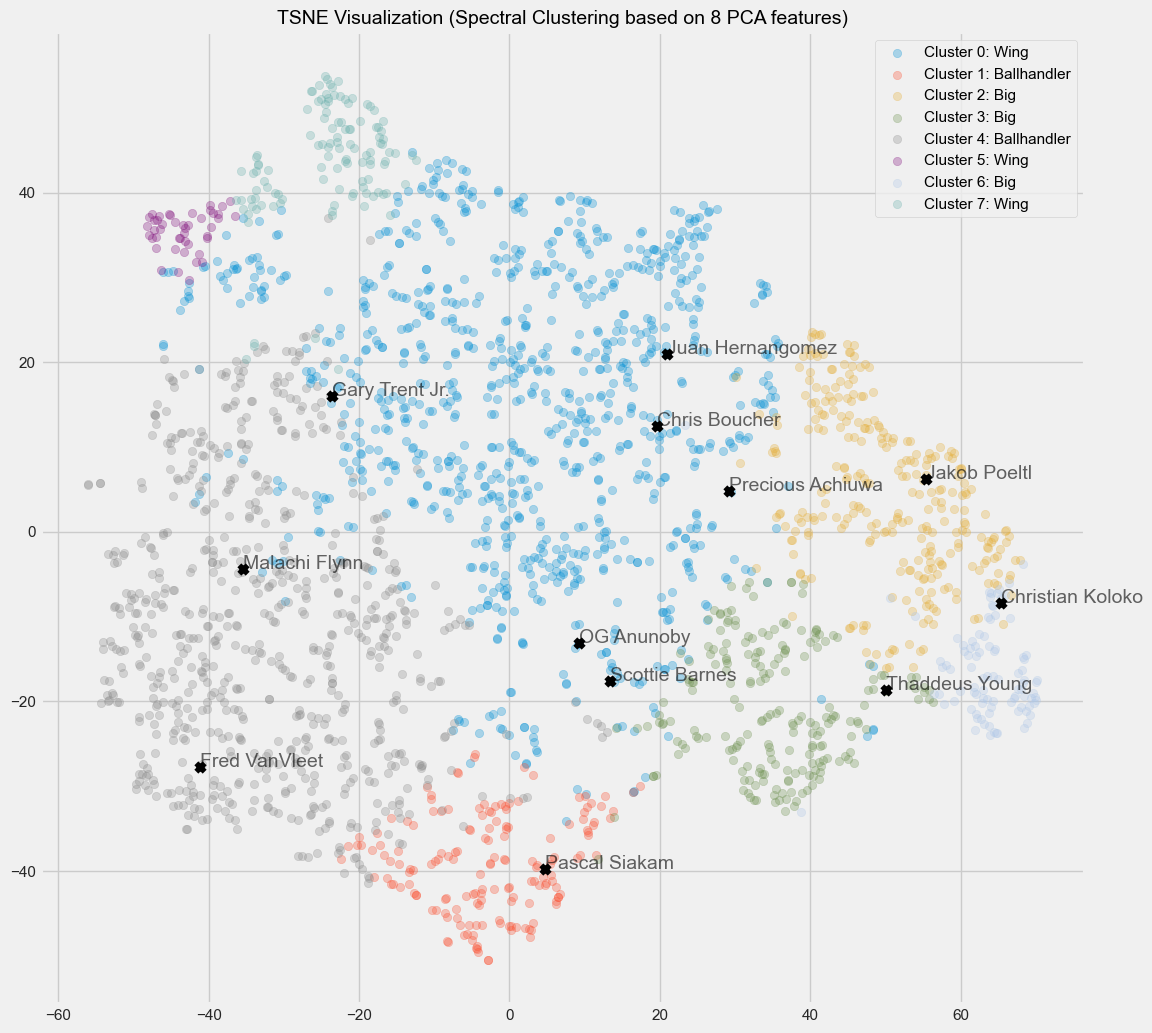

In [64]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Toronto Raptors') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## New Orleans Pelicans (#14)

In [66]:
display_team_distribution('New Orleans Pelicans')

2022-23 New Orleans Pelicans


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  player_cluster  \
0         CJ McCollum  2649     26.4   0.541   1.5  -0.7  0.8               4   
1     Trey Murphy III  2448     16.6   0.650   1.4   0.4  1.8               0   
2   Jonas Valančiūnas  1968     23.4   0.610   0.0  -0.4 -0.4               3   
3       Herbert Jones  1951     14.5   0.567  -1.9   1.7 -0.3               0   
4       Naji Marshall  1792     17.8   0.539  -1.9   0.0 -1.9               0   
5      Brandon Ingram  1538     30.8   0.582   2.2  -0.4  1.7               1   
6     Larry Nance Jr.  1381     11.9   0.649   0.0   2.0  2.0               2   
7       Jose Alvarado  1310     19.8   0.525  -2.0   0.7 -1.2               4   
8       Dyson Daniels  1042     11.6   0.503  -3.4   1.6 -1.8               0   
9     Zion Williamson   956     30.4   0.652   4.8   1.0  5.8               1   
10    Devonte' Graham   811     15.0   0.545  -0.4   0.6  0.2               7   
11       Jaxson Hayes   610     15.7   0.605  -2.2   1.0 -1.2               0   
12    Josh Richardson   533     14.5   0.550  -2.9   1.6 -1.3               0   
13  Willy Hernangómez   458     23.8   0.610  -0.2   0.5  0.3               3   

   player_cluster_discription  
0                       (PnR)  
1        (Spot Up+Transition)  
2              (Post Up+Roll)  
3        (Spot Up+Transition)  
4        (Spot Up+Transition)  
5                   (Iso+PnR)  
6              (Roll+Spot Up)  
7                       (PnR)  
8        (Spot Up+Transition)  
9                   (Iso+PnR)  
10               (Off Screen)  
11       (Spot Up+Transition)  
12       (Spot Up+Transition)  
13             (Post Up+Roll)

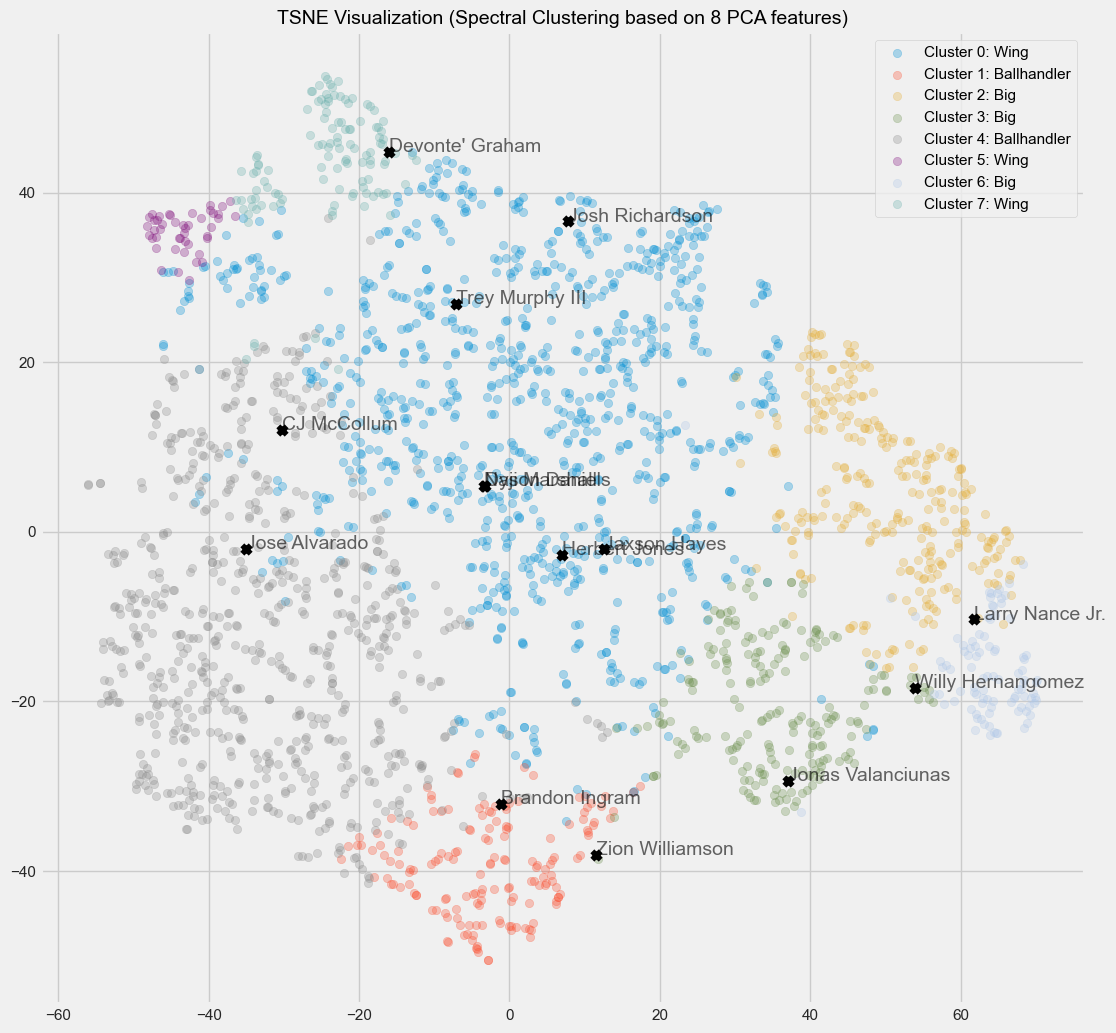

In [65]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'New Orleans Pelicans') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Atlanta Hawks (#15)

In [67]:
display_team_distribution('Atlanta Hawks')

2022-23 Atlanta Hawks


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  player_cluster  \
0     Dejounte Murray  2693     24.4   0.540   1.1   0.0  1.0               1   
1          Trae Young  2541     32.6   0.573   5.3  -2.0  3.3               4   
2        John Collins  2130     17.1   0.593  -1.4   0.2 -1.3               3   
3     De'Andre Hunter  2126     19.7   0.563  -1.9  -1.4 -3.3               0   
4      Onyeka Okongwu  1849     15.1   0.678   0.0   0.8  0.8               6   
5        Clint Capela  1730     15.7   0.656   2.3  -0.1  2.2               6   
6   Bogdan Bogdanović  1508     19.8   0.586   1.1  -0.7  0.5               7   
7          AJ Griffin  1401     17.9   0.577  -0.3  -0.5 -0.8               7   
8       Jalen Johnson  1042     16.0   0.554  -1.2   1.5  0.3               0   
9       Aaron Holiday   845     13.4   0.528  -2.9   0.9 -2.0               4   
10         Saddiq Bey   629     17.4   0.599   1.7  -1.2  0.5               0   
11     Justin Holiday   411     14.0   0.504  -3.1  -0.6 -3.7               7   

   player_cluster_discription  
0                   (Iso+PnR)  
1                       (PnR)  
2              (Post Up+Roll)  
3        (Spot Up+Transition)  
4                  (Roll+Cut)  
5                  (Roll+Cut)  
6                (Off Screen)  
7                (Off Screen)  
8        (Spot Up+Transition)  
9                       (PnR)  
10       (Spot Up+Transition)  
11               (Off Screen)

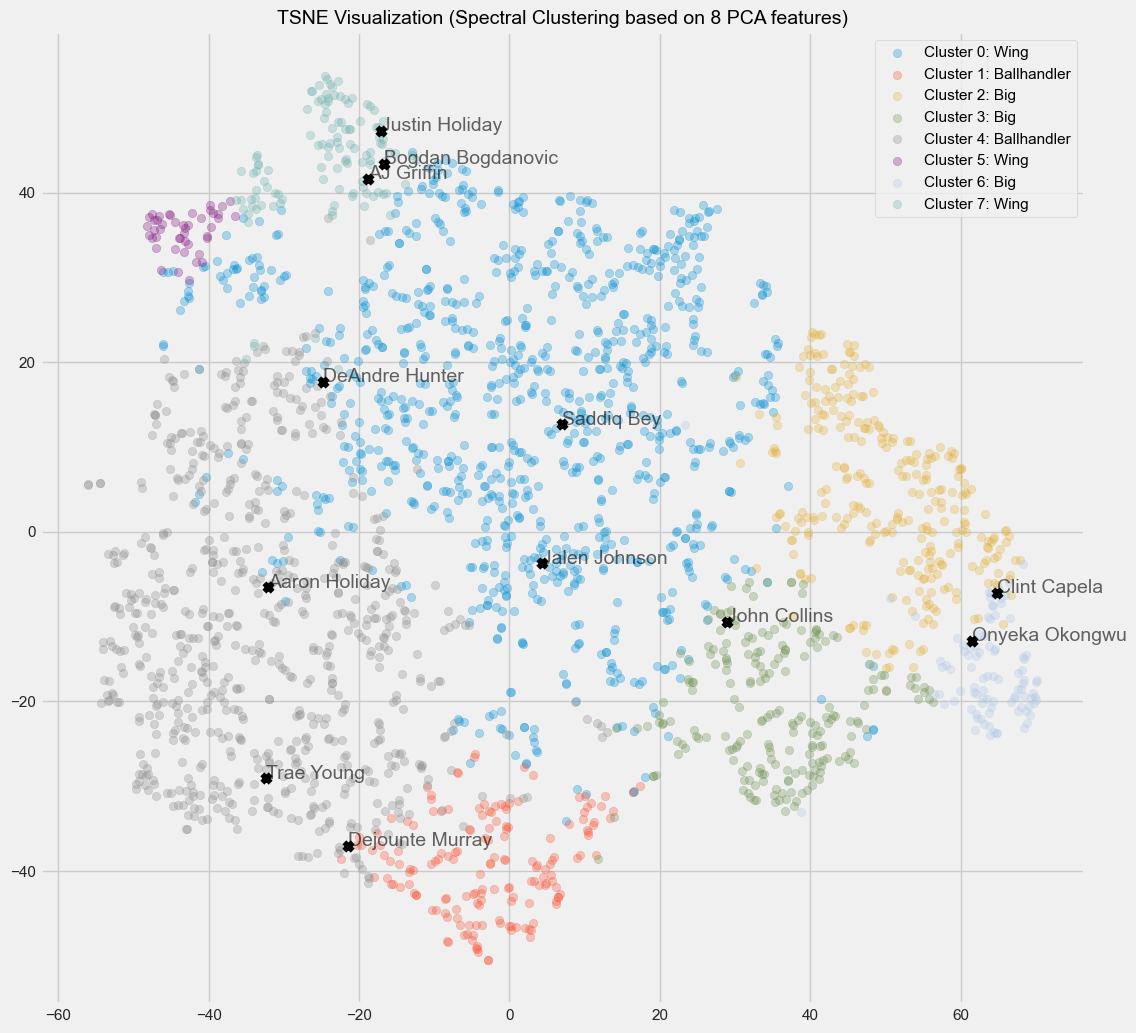

In [68]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Atlanta Hawks') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Los Angeles Lakers (#17)

In [69]:
display_team_distribution('Los Angeles Lakers')

2022-23 Los Angeles Lakers


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  \
0         Dennis Schröder  1986     18.6   0.545  -2.4  -0.5 -2.9   
1            LeBron James  1954     33.3   0.583   5.5   0.6  6.1   
2           Anthony Davis  1904     28.4   0.627   4.6   1.7  6.3   
3          Troy Brown Jr.  1860     12.1   0.561  -1.8   0.8 -1.0   
4           Austin Reaves  1843     16.2   0.687   0.6   0.1  0.7   
5       Russell Westbrook  1491     28.8   0.496  -0.2   0.1 -0.1   
6        Lonnie Walker IV  1297     20.2   0.570  -0.9  -0.5 -1.4   
7        Patrick Beverley  1211     10.6   0.548  -3.2   1.4 -1.8   
8          Wenyen Gabriel  1024     14.1   0.626  -2.3   0.1 -2.2   
9           Thomas Bryant   876     18.2   0.712   2.4  -0.1  2.3   
10          Rui Hachimura   738     17.4   0.553  -1.4  -0.5 -1.9   
11      Jarred Vanderbilt   625     12.5   0.598  -1.7   1.9  0.2   
12          Malik Beasley   621     20.9   0.521  -2.3  -0.6 -2.9   
13          Kendrick Nunn   528     23.3   0.503  -3.4  -1.6 -5.0   
14       D'Angelo Russell   526     22.6   0.610   3.1  -0.7  2.4   
15           Max Christie   512     10.4   0.566  -3.2   0.0 -3.1   
16  Juan Toscano-Anderson   365     10.4   0.558  -4.6   1.2 -3.4   

    player_cluster player_cluster_discription  
0                4                      (PnR)  
1                1                  (Iso+PnR)  
2                3             (Post Up+Roll)  
3                0       (Spot Up+Transition)  
4                4                      (PnR)  
5                1                  (Iso+PnR)  
6                0       (Spot Up+Transition)  
7                0       (Spot Up+Transition)  
8                6                 (Roll+Cut)  
9                2             (Roll+Spot Up)  
10               0       (Spot Up+Transition)  
11               0       (Spot Up+Transition)  
12               7               (Off Screen)  
13               4                      (PnR)  
14               4                      (PnR)  
15               0       (Spot Up+Transition)  
16               0       (Spot Up+Transition)

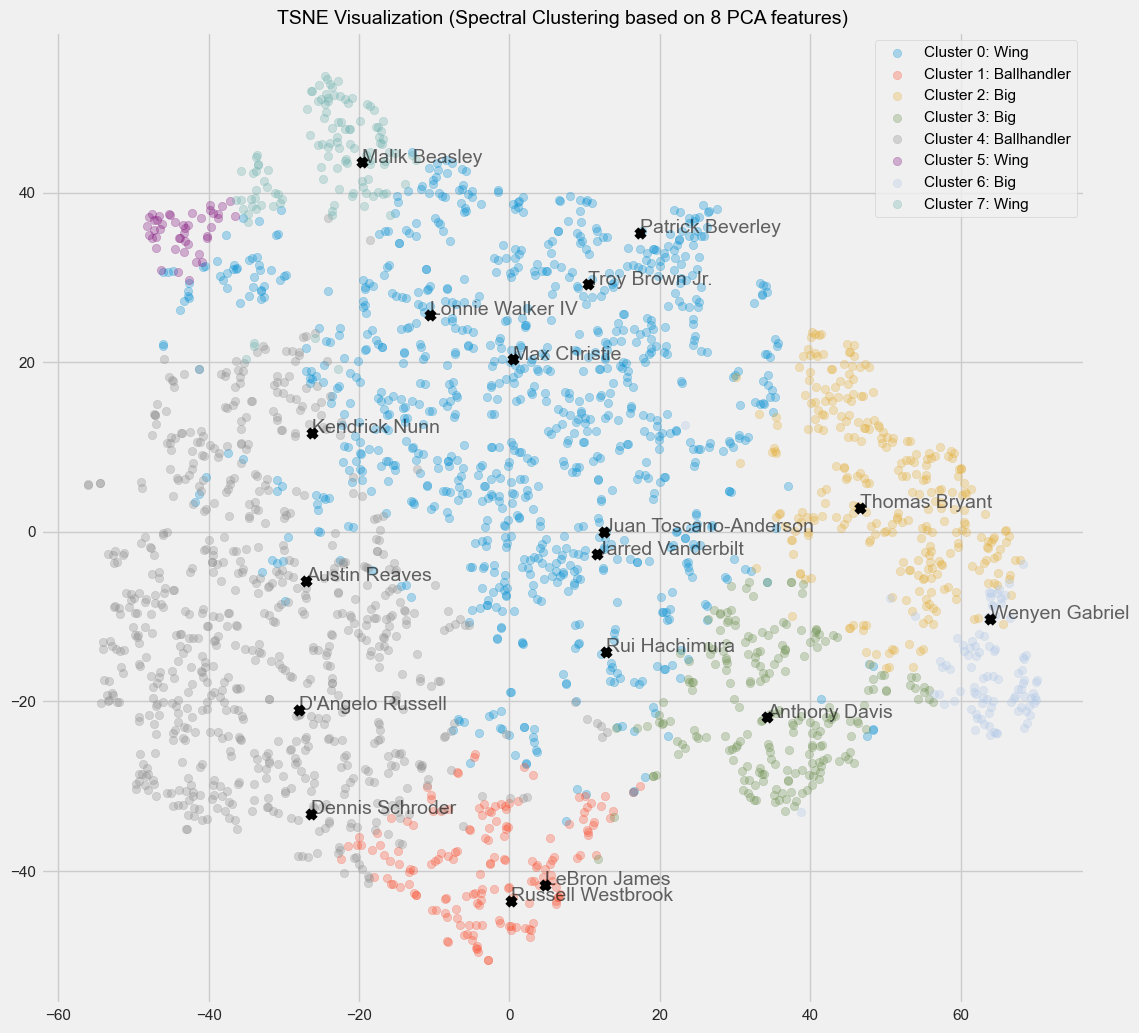

In [70]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Los Angeles Lakers') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Miami Heat (#18)

In [71]:
display_team_distribution('Miami Heat')

2022-23 Miami Heat


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  player_cluster  \
0         Bam Adebayo  2598     25.2   0.592   0.8   0.8  1.5               2   
1         Tyler Herro  2337     25.6   0.566   1.5  -0.8  0.6               4   
2           Max Strus  2272     17.6   0.557  -0.8  -0.9 -1.7               0   
3        Jimmy Butler  2138     25.6   0.647   6.7   2.0  8.7               1   
4        Caleb Martin  2077     14.4   0.571  -1.8   0.5 -1.2               0   
5        Gabe Vincent  1759     17.5   0.533  -3.1  -0.3 -3.4               4   
6          Kyle Lowry  1718     16.7   0.565  -0.7   0.8  0.2               4   
7      Victor Oladipo  1106     21.1   0.513  -2.9   0.8 -2.1               4   
8   Haywood Highsmith   969     12.5   0.517  -3.7   0.7 -3.1               0   
9     Duncan Robinson   691     17.9   0.534  -3.5  -1.5 -5.0               5   
10   Orlando Robinson   425     12.4   0.565  -2.7   0.7 -2.1               2   
11         Kevin Love   419     18.5   0.535  -1.0  -0.1 -1.1               0   
12     Dewayne Dedmon   350     21.2   0.576  -2.4   0.6 -1.8               2   

   player_cluster_discription  
0              (Roll+Spot Up)  
1                       (PnR)  
2        (Spot Up+Transition)  
3                   (Iso+PnR)  
4        (Spot Up+Transition)  
5                       (PnR)  
6                       (PnR)  
7                       (PnR)  
8        (Spot Up+Transition)  
9                  (Hand Off)  
10             (Roll+Spot Up)  
11       (Spot Up+Transition)  
12             (Roll+Spot Up)

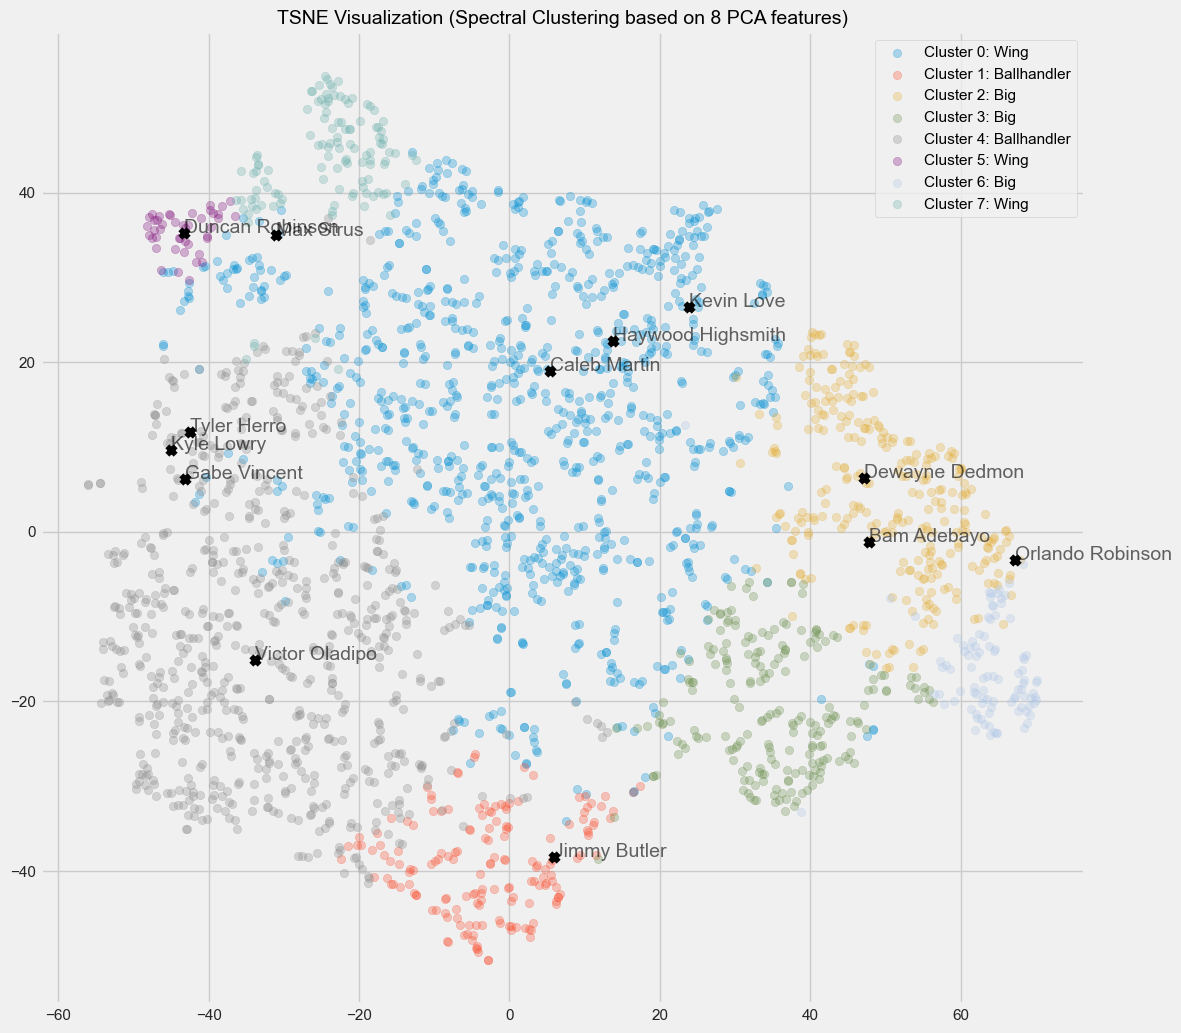

In [72]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Miami Heat') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)

## Golden State Warriors

In [73]:
display_team_distribution('Golden State Warriors')

2022-23 Golden State Warriors


player    mp  usg_pct  ts_pct  obpm  dbpm  bpm  player_cluster  \
0       Jordan Poole  2458     29.2   0.573  -0.1  -1.8 -1.9               4   
1     Draymond Green  2297     13.2   0.592  -1.8   2.6  0.8               0   
2      Klay Thompson  2279     26.4   0.576   1.5  -1.7 -0.3               7   
3       Kevon Looney  1958     10.6   0.639   0.9   1.3  2.1               6   
4      Stephen Curry  1941     31.0   0.656   7.5   0.1  7.5               4   
5   Donte DiVincenzo  1894     15.1   0.593  -0.6   1.3  0.7               0   
6   Jonathan Kuminga  1394     19.6   0.597  -1.7  -0.1 -1.7               0   
7       Anthony Lamb  1195     13.8   0.610  -1.6   0.4 -1.1               0   
8     Andrew Wiggins  1190     21.5   0.564  -0.1  -0.4 -0.5               0   
9        Moses Moody   817     14.6   0.603  -1.7  -0.9 -2.6               0   
10         Ty Jerome   816     14.9   0.594  -1.1   0.3 -0.8               4   
11    JaMychal Green   797     17.5   0.650  -0.7   0.2 -0.5               0   

   player_cluster_discription  
0                       (PnR)  
1        (Spot Up+Transition)  
2                (Off Screen)  
3                  (Roll+Cut)  
4                       (PnR)  
5        (Spot Up+Transition)  
6        (Spot Up+Transition)  
7        (Spot Up+Transition)  
8        (Spot Up+Transition)  
9        (Spot Up+Transition)  
10                      (PnR)  
11       (Spot Up+Transition)

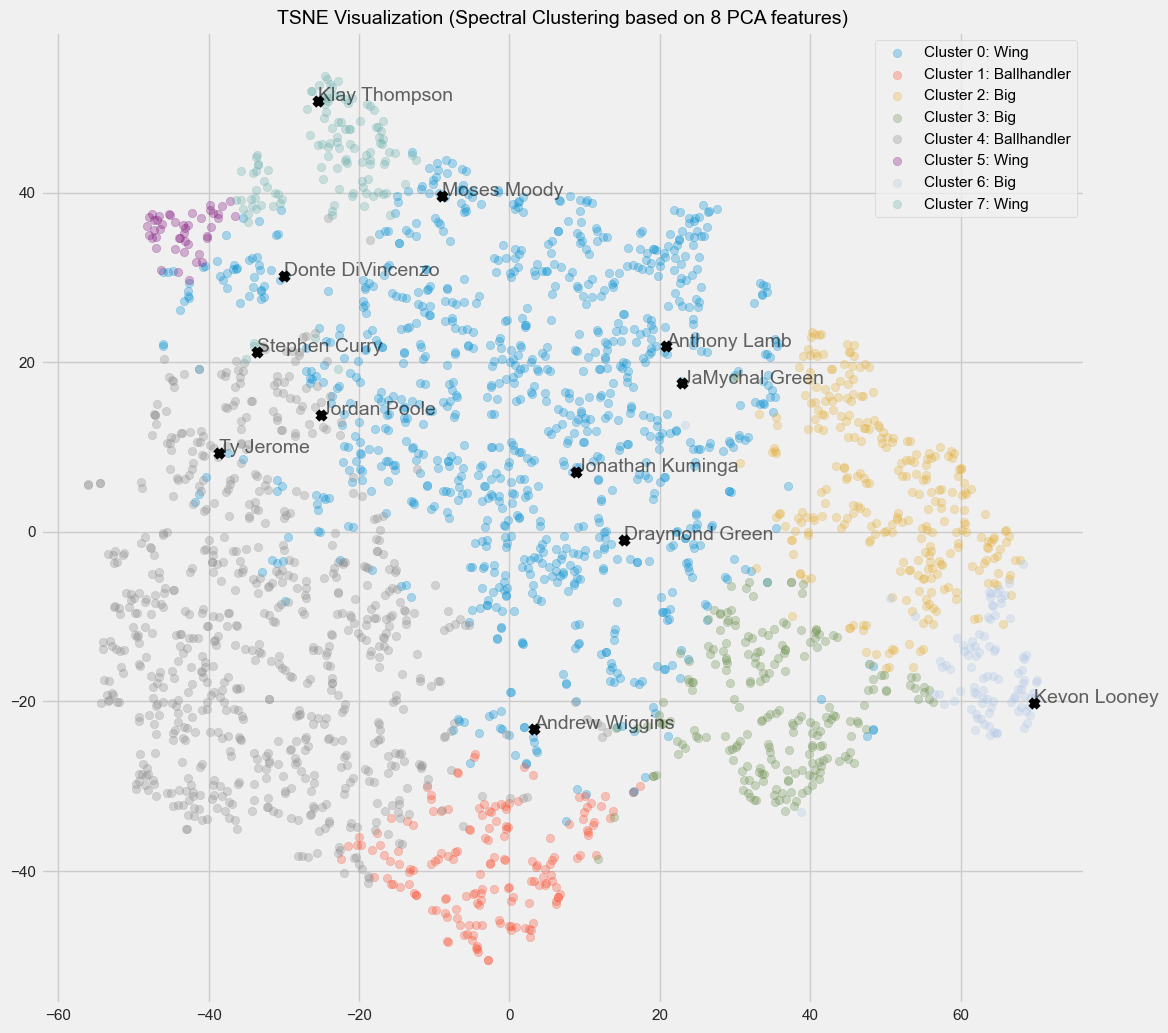

In [74]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Golden State Warriors') & 
                (df['season'] == 2022)].index
plot_players(lookup_idx)